In [6]:
from deps.dobot_api import DobotApiDashboard, DobotApiMove # deps is a folder and we are importing 2 classes from a file within the folder, these classes 
# allow us to control the robot informationally and movement oriented 
from deps import utils # importing the module utils from a file within the folder deps, don't import all files from deps, just utils
from deps import cv_core # this module houses all of the functions that are controlling and dealing with the camera and what it's doing
import numpy as np # numpy is a module, we want lots of functions from numpy so we import full module
import matplotlib.pyplot as plt # module that allows plotting, not used 
import cv2 # open cv, computer vision module with own GUI
from pynput import keyboard # module allows you to get callbacks from keyboard press (control robot using arrow keys)
import time # this module allows you to control timings 
import ipyparallel as ipp # module that allows code to be launched in parallel with other code
import heapq
import random
import math
import collections
import time

In [2]:
# rc = ipp.Cluster(n=1).start_and_connect_sync() # use this to move the robot with arrow keys and view camera feed at the same time 
# e0 = rc[0]
# e0.block = False
# e0.activate('0')

In [7]:
dash = DobotApiDashboard('192.168.1.6', 29999) # dash is the object that is connected to the robot and gets information from the dashboard
move = DobotApiMove('192.168.1.6', 30003) # the object that allows you to control the movement of the robot
# both classes we input ip address and port that we are communicating with 

# Setting speed so for collective happiness 
# dash.SpeedFactor(100)
# dash.AccJ(100)
# dash.AccL(100)
# dash.SpeedL(100)
# dash.SpeedJ(100)


In [28]:
dash.DisableRobot()

'0,{},DisableRobot();'

In [8]:
dash.ClearError() # dash is an object and ClearError is a method in dash that we are calling, clears error and warning when robot freezes and turns red
dash.EnableRobot() # enables the robot for use 

'0,{},EnableRobot();'

In [8]:
manmove = utils.ManualMove(move, dash) # initializing the class Keyboard from the module (file that houses functions (methods) and classes utils and we are passing the parameter dash
# we are giving the class Keyboard a connection to the robot which is called dash, dash is an object of the class dashboard
manmove.execute()

np.save('anchors.npy', manmove.coords)


Position saved!
Position saved!
Position saved!
Position saved!


In [20]:
grid = np.load('well_plate_96.npy')
dash.ClearError()
dash.EnableRobot()
for coord in grid:
    x,y = coord
    move.MovL(x,y,0,0)
    move.Sync()
    move.MovL(x,y,-35,0)
    move.Sync()
    move.MovL(x,y,0,0)
    move.Sync()

KeyboardInterrupt: 

In [4]:
cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')

cap = cv2.VideoCapture(0)
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944'])

cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # creating a GUI window cv2 is a module called open cv which has all the methods related to computer vision
cv2.resizeWindow('frame', 1348, 1011)
while(True):
    ret, frame = cap.read()
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@27.521] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


### Pump testing

In [ ]:

grid = np.load('well_plate_96.npy')
dash.ClearError()
dash.EnableRobot()
for i in range(40):
    print(i)
    move.MovL(289.601919,0.075039,-41.805241,0)
    move.Sync()
    move.MovL(289.601919,0.075039,-41.805241,120)
    move.Sync()
#print(grid[0][0], grid[0][1])
#for coord in grid:
   # x,y = coord
    #move.MovL(x,y,-38,0)

    #move.MovL(x,y,-80,0)
   # move.Sync()
   # move.MovL(x,y,-38,0)
    #move.Sync()

In [ ]:
manmove = utils.ManualMove(move, dash) # used to control robot with keyboard, uses key presses to control robot 
manmove.execute()

In [ ]:
manmove.coords

In [ ]:
base_offset = (manmove.coords[0] - np.array([250, 0, -90, 0]))[:2]
np.save('base_offset.npy', base_offset)

In [ ]:
def coordinate_rotation(x, y, angle):
    xPrime = x*np.cos(angle) - y*np.sin(angle)
    yPrime = x*np.sin(angle) + y*np.cos(angle)

    return xPrime, yPrime
    

In [ ]:
dash.ClearError()
dash.EnableRobot()
move.MovL(250, 0, -90, 0)


In [ ]:
utils.get_pose(dash, angle=True)

In [ ]:
%%px0
from deps import utils
from deps.dobot_api import DobotApiDashboard, DobotApiMove
dash = DobotApiDashboard('192.168.1.6', 29999)
move = DobotApiMove('192.168.1.6', 30003)
manmove = utils.ManualMove(move, dash)
manmove.execute()
coords = manmove.coords

In [ ]:
ar = e0.pull('coords')
coords = ar.get()
coords

In [ ]:
cap = cv2.VideoCapture(0)
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1200'])
cv_core.video_test(cap)

In [ ]:
np.save('anchors.npy', manmove.coords)
np.save('anchors_tk.npy', manmove.coords)

In [46]:
anchors = np.load('anchors.npy')
#np.save('anchors_tk.npy', anchors)

In [47]:
anchors

array([[ 256.82189 ,  -28.217839,  -38.817001, -350.000305],
       [ 309.652415,  -26.146832,  -38.821999, -350.      ],
       [ 318.825734,   35.751832,  -38.826061, -350.      ],
       [ 272.579972,   35.743979,  -38.832909, -349.999878]])

In [8]:
cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')




In [9]:
cameraMatrix[0]

array([9434.92810337,    0.        , 1341.17795578])

In [10]:
newCameraMatrix[0]

array([9116.92871094,    0.        , 1338.22245735])

## Calibration Petri Dish

In [6]:
#anchors = keys.coords
anchors = np.load('anchors.npy')
# anchors = [np.array([307.315193, -13.865066, -81,  -3.484534]),
#  np.array([316.442224,  49.591866, -81,  -3.484533]),
#  np.array([268.040607,  48.172406, -81,  -3.484533]),
#  np.array([260.923249, -14.987419, -81,  -3.484531])]

# anchor positions, positions of the laser that the camera recognizes to create a transformation matrix
# allows you to transform pixel coordinates of an object to actual robot coordinates 

# computer vision stuff

cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')

# cameraMatrix = np.load('./cam_matrices/cam_mtx.npy')
# dist = np.load('./cam_matrices/dist.npy')
# newCameraMatrix = np.load('./cam_matrices/newcam_mtx.npy')
template = cv2.imread('laser_template.png', 0)
w, h = template.shape[::-1]

# cap = cv2.VideoCapture(0)
# cap = cv_core.set_res(cap, cv_corfind_contourse.camera_res_dict['1200'])

# cv2.namedWindow('frame',  cv2.WINDOW_NORMAL)
# cv2.resizeWindow('frame', 1348, 1011)

dash.ClearError()
dash.EnableRobot()


recorded = []
for idx, anchor in enumerate(anchors):
    x,y,z,r = anchor
    move.MovL(x,y,z,r)
    move.Sync()

    #while(True):
    cap = cv2.VideoCapture(0)
    cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944'])

    cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # creating a GUI window cv2 is a module called open cv which has all the methods related to computer vision
    cv2.resizeWindow('frame', 1348, 1011)

    ret, frame = cap.read() # how to access camera information, gives single frame that has been captured by the camera at the time of execution
    # gives ret which is a boolean (true/false) true if frame captured, frame gives a numpy array that is basically the image (if color, 3 channel array rgb)
    
    
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix) # need these 3 parameters to undistort the frame and give a new undistorted frame
    
    
    
    plot_img = frame.copy() # create a copy of the variable frame (create a copy of the image)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # turn frame to grayscale 
    (minVal, maxVal, minLoc, maxLoc)=cv2.minMaxLoc(gray) # gives location of minimum and maximum pixel value, gives coordinates in pixels
    a, b = maxLoc # unpack max location into 2 variables, the x and y (a and b) in pixels
    
    top_left = (a-w, b-h) # make white rectangle around desired maximum pixel values
    bottom_right = (a+w, b+h)

    mask = np.zeros_like(frame) # brightest part not always the center point, we want to isolate the bright spot, we apply a mask onto the image 
    # we take a grayscale image and we apply a mask around the bright spot, we create absolute black image 
    cv2.rectangle(mask,top_left, bottom_right, (255,255,255), -1) # we create filled white rectangle around the bright spot 
    cv2.rectangle(plot_img,top_left, bottom_right, (255,255,255), 2) # puts white hollow rectangle onto the visual image 
    result = cv2.bitwise_and(frame.astype('uint8'), mask.astype('uint8')) # we multiply the frame by the mask which leaves only the bright spot
    gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY) # result given in rgb and we want to go to grayscale, gives one grayscale array instead of 3 BGR
    ret, thresh = cv2.threshold(gray_result,240,255,cv2.THRESH_BINARY) # apply thresholding to take brightest desired pixels and ignore all other values
    M = cv2.moments(thresh) # this is what is finding the center by calculating the moments of the bright blob, calculates center of mass of a pixel blob
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(plot_img, (cX, cY), 5, (0, 255, 0), 2) # drawing a circle around the brightest blob for visual purposes 
        recorded.append((cX, cY)) # we record the x and y pixel values of the center of the blob so we can map the location onto the robots coordinates, at that point
        

    cv2.imshow('frame',plot_img) # shows the image
    #cv2.imwrite(f'anchor_{idx}.jpg', plot_img)
    cv2.waitKey(0) # index zero wait key, tells the computer to wait for any key press before continuing execution
    cap.release() # releases the camera from control of the computer, disconnects the camera from the computer and empties memory
   
cv2.destroyAllWindows() # when 4 loop finishes it destroys (closes) the graphical window 

[ WARN:0@235.274] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@238.627] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@242.087] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@245.390] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [8]:
anchors = np.load('anchors.npy')


cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')


template = cv2.imread('laser_template.png')
w, h = template.shape[:2]


dash.ClearError()
dash.EnableRobot()


recorded = []
for idx, anchor in enumerate(anchors):
    x,y,z,r = anchor
    move.MovL(x,y,z,r)
    move.Sync()

    #while(True):
    cap = cv2.VideoCapture(0)
    cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944'])

    cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # creating a GUI window cv2 is a module called open cv which has all the methods related to computer vision
    cv2.resizeWindow('frame', 1348, 1011)

    ret, frame = cap.read() # how to access camera information, gives single frame that has been captured by the camera at the time of execution
    # gives ret which is a boolean (true/false) true if frame captured, frame gives a numpy array that is basically the image (if color, 3 channel array rgb)
    
    
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix) # need these 3 parameters to undistort the frame and give a new undistorted frame
    plot_img = frame.copy()


    res = cv2.matchTemplate(frame,template, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv2.rectangle(plot_img,top_left, bottom_right, 255, 2)


    mask = np.zeros_like(frame) # brightest part not always the center point, we want to isolate the bright spot, we apply a mask onto the image 
    # we take a grayscale image and we apply a mask around the bright spot, we create absolute black image 
    cv2.rectangle(mask,top_left, bottom_right, (255,255,255), -1) # we create filled white rectangle around the bright spot 
    cv2.rectangle(plot_img,top_left, bottom_right, (255,255,255), 2) # puts white hollow rectangle onto the visual image 
    result = cv2.bitwise_and(frame.astype('uint8'), mask.astype('uint8')) # we multiply the frame by the mask which leaves only the bright spot
    gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY) # result given in rgb and we want to go to grayscale, gives one grayscale array instead of 3 BGR
    ret, thresh = cv2.threshold(gray_result,240,255,cv2.THRESH_BINARY) # apply thresholding to take brightest desired pixels and ignore all other values
    M = cv2.moments(thresh) # this is what is finding the center by calculating the moments of the bright blob, calculates center of mass of a pixel blob
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(plot_img, (cX, cY), 5, (0, 255, 0), 2) # drawing a circle around the brightest blob for visual purposes 
        recorded.append((cX, cY)) # we record the x and y pixel values of the center of the blob so we can map the location onto the robots coordinates, at that point
        

    cv2.imshow('frame',plot_img) # shows the image
    #cv2.imwrite(f'anchor_{idx}.jpg', plot_img)
    cv2.waitKey(0) # index zero wait key, tells the computer to wait for any key press before continuing execution
    cap.release() # releases the camera from control of the computer, disconnects the camera from the computer and empties memory
   
cv2.destroyAllWindows() # when 4 loop finishes it destroys (closes) the graphical window 

[ WARN:0@253.618] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@257.794] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@261.759] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@265.982] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [ ]:
cv2.imwrite('laser_template.png', frame)

## Move Pipette down

In [ ]:
dash.ClearError()
dash.EnableRobot()
move.MovL(315.233371,  49.014043, -97.242516,  -1.563194)

## Calculate the transformation matrix

In [7]:
# this is the cell that calculates the transformation matrix 
xys = [(arr[0], arr[1]) for arr in anchors]
robot_coor = utils.assign_corners(xys, reverse=True) # assign corners to the robot coordinates at the 4 corner positions 
pix_coor = utils.assign_corners(recorded) # assign corners to the pixel coordinates at the 4 corner positions 

features_mm_to_pixels_dict = {} # setting up an empty dictionary to store the mapping of the corners from coordinate to pixel
for key, value in robot_coor.items():
    features_mm_to_pixels_dict[value] = pix_coor[key]


tf_mtx = cv_core.compute_tf_mtx(features_mm_to_pixels_dict) # method of cv_core module that calculates transformation matrix
np.save('tfm_mtx.npy', tf_mtx)
# takes the dictionary and solves the system of linear equations that gives the transformation matrix and gives the actual relation between the pixels and millimeters 

### Discerning isolated cuboids

In [4]:
tf_mtx = np.load('tfm_mtx.npy')

def calc_centers(conts):
    centers = []
    #print(r,a,b)
    for i in range(len(conts)):
        M = cv2.moments(conts[i])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append([cX,cY])
    return centers  



def mindis(centers,r,a,b):
    val = 2.5
    res = []
    ignore = set()
    print(len(centers))
    dis = collections.defaultdict(lambda: np.inf)
    
    for i in range(len(centers)):
        xa,ya = centers[i]
        c_dis = math.sqrt(abs(a-xa) ** 2 + abs(b-ya) ** 2)
        if c_dis > r:
            ignore.add(i)
        x,y, _ = tf_mtx @ (xa,ya,1)
        for j in range(i+1,len(centers)):
            xb,yb = centers[j]
            x1,y1, _ = tf_mtx @ (xb,yb,1)
            distance = math.sqrt(abs(x1-x) ** 2 + abs(y1-y) ** 2)
            dis[(i, (x,y))] = min(dis[(i, (x,y))], distance)
            dis[(j, (x1,y1))] = min(dis[(j, (x1,y1))],distance)
                
    dist = list(sorted(dis.items(), key = lambda item : item[1], reverse = True))
    
    for i in range(len(dist)):
        if dist[i][0][0] in ignore or dist[i][1] < val:
            continue
        res.append(dist[i])
    return res
    #return list(filter(lambda x: x[1] >= val, dist))         

### Find petri dish

In [6]:
# avoid searching for petri dish in every iteration
cont = cv_core.Contours() # define class of methods for cuboid detection, initialize class
offset = 100 # create smaller inner circle in petri dish to locate cuboids 
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944']) # sets the resolution of the camera to 1200 x 1600
edit = 10  # how much to adjust offset by
tf_mtx = np.load('tfm_mtx.npy')
anchors = np.load('anchors.npy')
cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')
dr = 0
cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame', 1348, 1011)
while(True):
    
    ret,frame= cap.read()
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)
    pt = cont.find_contours(frame, 10, offset)
    a,b,r = pt # gives the x y coordinates and the radius of the circle
    plot_img = frame.copy() # create a copy of the frame so things can be drawn on it without altering original image
    ra = r + dr
    cv2.circle(plot_img, (a, b), ra, (3, 162, 255), 2) # circles being drawn on image to locate petri dish
    cv2.circle(plot_img, (a, b), 1, (0, 0, 255), 3)
    cv2.circle(plot_img, (a, b), ra - offset+10, (0, 255, 0), 2)

    cv2.imshow('frame',plot_img) # this just displays the image 

    k = cv2.waitKey(0)

    if k == ord('q'): # satisfied with the circles
        break
    elif k == ord('i'):  # increase the size of petri dish circle, i.e, decrease offset
        offset -= edit
    elif k == ord('d'): # decrease the size of petri dish circle, i.e, increase offset
        offset += edit  
    elif k == ord('s'):  # increase the size of petri dish circle, i.e, decrease offset
        dr -= edit
    elif k == ord('w'): # decrease the size of petri dish circle, i.e, increase offset
        dr += edit      
          
cap.release()
cv2.destroyAllWindows()

[ WARN:0@13.891] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


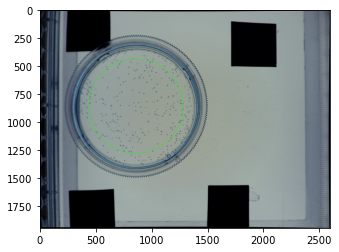

In [7]:
plt.imshow(plot_img)

## Cuboid Recognition and Positioning

In [7]:
cont = cv_core.Contours() # define class of methods for cuboid detection, initialize class
tf_mtx = np.load('tfm_mtx.npy')
def on_change(val): pass

offset = 80 # create smaller inner circle in petri dish to locate cuboids 
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944']) # sets the resolution of the camera to 1200 x 1600

# cameraMatrix = np.load('./cam_matrices/cam_mtx.npy') # uploading the camera matrices for the calibration of the camera for undistortion
# dist = np.load('./cam_matrices/dist.npy') 
# newCameraMatrix = np.load('./cam_matrices/newcam_mtx.npy') 

cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy') # uploading the camera matrices for the calibration of the camera for undistortion
dist = np.load('./cam_matrices/dist_1944.npy') 
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy') 

cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame', 1348, 1011) # set resolution of window
cv2.createTrackbar('Manual Lock', 'frame', 0, 1, on_change) # create trackbar between values of 0 and 1, basically a switch (manual lock of the circle recognition)
# stops trying to recognize the petri dish (locked) increases performance of more fps because it recognizes a lot of circles which takes time so this locks it 
# circle recognition needs optimizing 
cv2.createTrackbar('Mask Offset', 'frame', offset, 150, on_change) # second trackbar allows control of offset which changes the size of the petri dish detection circle
cv2.setMouseCallback('frame', cont.mousecallback) # set a callback function for double clicks of the mouse, this allows us to select cuboids by double clicking
# initializes a double click response to select a certain contour on the screen 

idx = 0 
prev_point = (0,0,0)
while(True): # we want a video stream so we want a while loop to continuously take new images until loop is broken
    ret, frame = cap.read()
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)
    val = cv2.getTrackbarPos('Manual Lock', 'frame') # checks position of trackbar for manual lock, if trackbar 1, then val = 1, this turns off circle detection
    offset = cv2.getTrackbarPos('Mask Offset', 'frame') # the trackbar with the offset, changes the offset value for the circle
    if val == 1:
        cont.locked = True
    else:
        cont.locked = False

    # if cont.best_circ is None:
    #     while cont.best_circ is None:
    #         pt = cont.find_contours(frame, 10, offset)
    # else:
    pt = cont.find_contours(frame, 5, offset) # 10 og,takes the frame and looks for the circle of the petri dish, also looks for the cuboids 

    a,b,r = pt # gives the x y coordinates and the radius of the circle
    plot_img = frame.copy() # create a copy of the frame so things can be drawn on it without altering original image
    cv2.circle(plot_img, (a, b), r, (3, 162, 255), 2) # circles being drawn on image to locate petri dish
    cv2.circle(plot_img, (a, b), 1, (0, 0, 255), 3)
    cv2.circle(plot_img, (a, b), r - offset, (0, 255, 0), 2)
    # print(cont.big_circ[2])
    cv2.circle(plot_img, cont.big_circ[:2], int(cont.big_circ[2]), (0, 0, 255), 2)
    cv2.putText(plot_img, f"{cont.big_circ[2]*2}px = 60mm", (cont.big_circ[0]-25, cont.big_circ[1] - cont.big_circ[2] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2) # how to decide size of cuboids, use diameter of petri dish being 60 mm to approximate size of cuboids
    # just a text sign around the biggest circle of the image (petri dish) saying that this circle is 60 mm

    cv2.drawContours(plot_img, cont.singular, -1,(0,255, 0),2) # two lists of contours (cuboid contours) that we draw on the plotting image
    cv2.drawContours(plot_img, cont.clusters, -1,(0,0,255),2) # we do this to distinguish between clusters and cuboids 

    if cont.selected: # if we selected cuboids with the double click, we draw them in blue
        cv2.drawContours(plot_img, cont.selected, -1,(255,0,0),2) # BGR, this is blue contour 

    # for c in cont.singular: # we find the centers of the contours similar to how we found centers with the calibration step
    #     # compute the center of the contour
    #     M = cv2.moments(c)
    #     cX = int(M["m10"] / M["m00"]) # the function moments gives a mysterious dictionary with elements of matrix, it seems that you gotta divide one element by another to get x&y
    #     cY = int(M["m01"] / M["m00"])
    
    #     cv2.circle(plot_img, (cX, cY), 2, (0, 0, 255), -1) # just draw a cirlce around the contour 
    #     cv2.putText(plot_img, f"{cX},{cY}", (cX - 20, cY - 20),
    #     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # cv2.putText(plot_img, f"{cv2.contourArea(c)}", (cX - 20, cY - 20), # putting the area of the cuboids onto the screen as text next to the cuboid
        # cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
#out.write(with_contours)

    for c in cont.clusters: # same thing for clustes as above but no printed text for cuboid area or coordinate
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        # draw the contour and center of the shape on the image
        #cv2.drawContours(plot_img, [c], -1, (0, 255, 0), 2)
        cv2.circle(plot_img, (cX, cY), 2, (0, 0, 255), -1)
        # cv2.putText(plot_img, f"{cX},{cY}", (cX - 20, cY - 20),
        # cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)

        # cv2.putText(plot_img, f"{cv2.contourArea(c)}", (cX - 20, cY - 20),
        # cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)


    if prev_point is pt:
        idx += 1
    else:
        idx = 0
    prev_point = pt


    if idx >= 30: # if circle stays same for awhile then it will show as locked (30 frames the same)
        message = 'LOCKED'
        color = (0,255,0)
    else:
        message = 'SEARCHING' # more text messages 
        color = (0,0,255)

    cv2.putText(plot_img, "TARGET:", (25,25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2) # text messages, target displays constantly
    cv2.putText(plot_img, f"{message}", (125,25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2) # displays message locked or searching
    cv2.putText(plot_img, f"Found: {len(cont.singular)}", (25,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2) # how many cuboids it sees


    cv2.imshow('frame',plot_img) # this just displays the image 
    if cv2.waitKey(1) & 0xFF == ord('q'): # if you press q, the while loop will break and the video and locating will stop, then the camera is released and windows destroyed
        break
#cv2.waitKey(0)
cap.release()
cv2.destroyAllWindows()

[ WARN:0@978.076] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


## Move to selected cuboid for height adjustment

In [8]:
dash.ClearError()
dash.EnableRobot()
M = cv2.moments(cont.selected[0])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
X, Y, _ = tf_mtx @ (cX, cY, 1)
move.MovL(X, Y, -45.683968, 0)
move.Sync()
#utils.correct_J4_angle(0, dash, move)

'0,{},Sync();'

## Calibrate for well plate grid

In [11]:
keys = utils.Keyboard(dash) # initializing the class Keyboard from the module (file that houses functions (methods) and classes utils and we are passing the parameter dash
# we are giving the class Keyboard a connection to the robot which is called dash, dash is an object of the class dashboard
keys.execute() # Keyboard has a method called execute, use this to record the position of the robot by pressing s. if finished press esc
# we want to find corners of well plate so we record the position of the 4 corners and use this information later, just one use of execute of class keyboard
print(f'\nCoords: {keys.coords}')

Position saved!
Position saved!
Position saved!
Position saved!
Special key pressed: Key.esc

Coords: [array([ 228.080266, -170.380843,  -35.067741,  -24.7607  ]), array([ 237.997984, -111.289629,  -34.07267 ,  -13.06407 ]), array([ 341.331115, -113.226047,  -34.599758,   -6.351851]), array([ 333.984161, -174.307534,  -34.873409,  -15.5604  ])]


In [12]:
# this cell calculates the grid for the 96 and the 384 well plate well plate
well_plate = utils.assign_corners(keys.coords, reverse=True) # assign_corners is a method in the module utils 
left_side_points = np.linspace(well_plate['ul'], well_plate['ll'], 12)[:,:2]  ## for 96 well plate
right_side_points = np.linspace(well_plate['ur'], well_plate['lr'], 12)[:,:2]
# left_side_points = np.linspace(well_plate['ul'], well_plate['ll'], 24)[:,:2]  # for 384 well plate
# right_side_points = np.linspace(well_plate['ur'], well_plate['lr'], 24)[:,:2]
grid = []
for i in range(len(left_side_points)):
    x1, y1 = left_side_points[i]
    x2, y2 = right_side_points[i]
    a = (x2-x1)/(y2-y1)
    b = x1 - a*y1
    ys = np.linspace(y1,y2,8) 
    xs = a*ys + b
    grid += (list(zip(xs,ys)))

np.save('well_plate_96.npy',np.array(grid))

### Manual (developer mode)

In [13]:
start_idx = 0  # start from this well

move.JointMovJ(-30,0,0,0)
tf_mtx = np.load('tfm_mtx.npy')
anchors = np.load('anchors.npy')
ctrs = []
grid = np.load('well_plate_96.npy')


cont = cv_core.Contours() # define class of methods for cuboid detection, initialize class
offset = 100 # create smaller inner circle in petri dish to locate cuboids 
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944']) # sets the resolution of the camera to 1200 x 1600

cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')

cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame', 1348, 1011) # set resolution of window
idx = 0
edit = 20
calibration_z = np.mean(anchors[:,2])
z_offset = 35
# print(calibration_z)
prev = [-1,-1]

#for j in range(96): # we want a video stream so we want a while loop to continuously take new images until loop is broken
while(True):    
    for i in range(5):   # TODO: Test with this and see if you still need five presses on the spacebar # Sarmad Hassan
        ret, frame = cap.read()
        
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)

    
    # getting circles from above cell now so don't need the commented code below (TODO: test if this works)
    pt = cont.find_contours(frame, 10, offset) # takes the frame and looks for the circle of the petri dish, also looks for the cuboids 
    a,b,r = pt # gives the x y coordinates and the radius of the circle
    plot_img = frame.copy() # create a copy of the frame so things can be drawn on it without altering original image
    cv2.circle(plot_img, (a, b), r, (3, 162, 255), 2) # circles being drawn on image to locate petri dish
    cv2.circle(plot_img, (a, b), 1, (0, 0, 255), 3)
    cv2.circle(plot_img, (a, b), r - offset, (0, 255, 0), 2) 
    cv2.drawContours(plot_img, cont.singular, -1,(0,255, 0),2) # two lists of contours (cuboid contours) that we draw on the plotting image
    cv2.drawContours(plot_img, cont.clusters, -1,(0,255,0),2)
    cv2.circle(plot_img, (a, b), r - offset - edit, (0, 255, 255), 2)  

    cv2.putText(plot_img, f"Found: {len(cont.singular)}", (25,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2) # how many cuboids it sees
  
    cs = cv_core.calc_centers(cont.singular)
    ds = utils.mindis(cs, r-offset-edit, a, b, tf_mtx)
    # print('ds: ', len(ds))
    #print(len(cont.singular))
    #print(max(ds))
    #print(cont.singular[ds[0][0]])
    if len(ds)==0:
        print('Threshold too high')
        break
    cv2.drawContours(plot_img, [cont.singular[ds[0][0][0]]],-1,(255,0,0),2)
    
    cv2.imshow('frame',plot_img) # this just displays the image 
    
    
    
    k = cv2.waitKey(0)
    if k == ord('q'): # if you press q, the while loop will break and the video and locating will stop, then the camera is released and windows destroyed
        break
    elif k == ord('e'):
        #print(len(cont.singular))
        if len(cont.singular) >= 1:
            # center = cont.contour_centers(cont.singular)[0]            
            #center = random.choice(cont.contour_centers(cont.singular))
            #X, Y, _ = tf_mtx @ (center[0], center[1], 1)
            
            X,Y = ds[0][0][1]

            if abs(X-prev[0]) <= 0.5 and abs(Y-prev[1]) <= 0.5:
                print('Shake time')
                time.sleep(10)
                continue
            prev = [X,Y]
            move.MovL(X, Y, calibration_z + z_offset, 0)
            move.Sync()
            utils.correct_J4_angle(0, dash, move)
            # utils.correct_J4_angle(-360, dash, move)
            # utils.correct_J4_angle(0, dash, move)
            move.RelMovL(0,0, -z_offset) #(0,0,-36)
            move.Sync()
            utils.correct_J4_angle(120, dash, move)
            move.RelMovL(0,0,z_offset) #(0,0,36) #24 works!!
            move.Sync()
            x,y = grid[idx+start_idx]
            idx += 1
            move.MovL(x,y,calibration_z + z_offset, 120)
            move.Sync()
            utils.correct_J4_angle(120, dash, move)
            move.RelMovL(0,0,-33) #(0,0,-27)
            move.Sync()
            utils.correct_J4_angle(-100, dash, move)
            move.RelMovL(0,0, 33) #(0,0,-27)
            move.Sync()
    
    
    elif k == ord('r'): # refill well if no cuboid picked
        idx -= 1
    elif k == ord('i'):  # increase the size of petri dish circle, i.e, decrease offset
        edit -= 10
    elif k == ord('d'): # decrease the size of petri dish circle, i.e, increase offset
        edit += 10              
    # elif k == ord('w'):
    #     move.MovL(water_dish[0], water_dish[1], water_dish[2]+35, water_dish[3])
    #     move.Sync()
    #     move.RelMovL(0,0,-35)
    #     move.Sync()
    #     utils.correct_J4_angle(480, dash, move)
    #     move.movL(x,y,z,r) # move back to where??
                
            
cap.release()
cv2.destroyAllWindows()


[ WARN:0@1186.040] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


243
240
240
241
234
231


### Automated

In [5]:
start_idx = 0  # start from this well
break_point = 8 # break to add water after (break_point)^th iteration

grid = np.load('well_plate_96.npy')
move.JointMovJ(-30,0,0,0)
tf_mtx = np.load('tfm_mtx.npy')
anchors = np.load('anchors.npy')
ctrs = []
grid_size = len(grid)
edit = 20
cont = cv_core.Contours() # define class of methods for cuboid detection, initialize class
offset = 130 # create smaller inner circle in petri dish to locate cuboids 
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944']) # sets the resolution of the camera to 1200 x 1600

# don't need this now since not undistorting

# cameraMatrix = np.load('./cam_matrices/cam_mtx.npy') # uploading the camera matrices for the calibration of the camera for undistortion
# dist = np.load('./cam_matrices/dist.npy') 
# newCameraMatrix = np.load('./cam_matrices/newcam_mtx.npy') 

cameraMatrix = np.load('./cam_matrices/cam_mtx_1944.npy')
dist = np.load('./cam_matrices/dist_1944.npy')
newCameraMatrix = np.load('./cam_matrices/newcam_mtx_1944.npy')

# cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
# cv2.resizeWindow('frame', 1348, 1011) # set resolution of window
idx = 0

calibration_z = np.mean(anchors[:,2])
z_offset = 35
prev = [-1,-1]

j=0
while j < grid_size-start_idx:
#for j in range(grid_size-start_idx): # we want a video stream so we want a while loop to continuously take new images until loop is broken

    for i in range(5):   # TODO: Test with this and see if you still need five presses on the spacebar # Sarmad Hassan
        ret, frame = cap.read()
  
    frame = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)

    
    # getting circles from above cell now so don't need the commented code below (TODO: test if this works)
    pt = cont.find_contours(frame, 10, offset) # takes the frame and looks for the circle of the petri dish, also looks for the cuboids 
    a,b,r = pt # gives the x y coordinates and the radius of the circle
    #plot_img = frame.copy() # create a copy of the frame so things can be drawn on it without altering original image
    #cv2.circle(plot_img, (a, b), r, (3, 162, 255), 2) # circles being drawn on image to locate petri dish
    #cv2.circle(plot_img, (a, b), 1, (0, 0, 255), 3)
    #cv2.circle(plot_img, (a, b), r - offset, (0, 255, 0), 2) 
    #cv2.drawContours(plot_img, cont.singular, -1,(0,255, 0),2) # two lists of contours (cuboid contours) that we draw on the plotting image
    #cv2.drawContours(plot_img, cont.clusters, -1,(0,255,0),2)
    #cv2.circle(plot_img, (a, b), r - offset - edit, (0, 255, 255), 2)  

    #cv2.putText(plot_img, f"Found: {len(cont.singular)}", (25,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2) # how many cuboids it sees
  
    cs = calc_centers(cont.singular)
    ds = mindis(cs, r-offset-edit, a, b)
    print(f'Well index = {j}, len(ds) = {len(ds)}')
    #cv2.drawContours(plot_img, [cont.singular[ds[0][0][0]]],-1,(255,0,0),2)
    
    #cv2.imshow('frame',plot_img) 
    
    
    if len(cont.singular) >= 1:
        
        
        if not ds:
            print('ds list empty, fix pls')
            j -= 1
            continue

        X,Y = ds[0][0][1]
        if abs(X-prev[0]) <= 0.5 and abs(Y-prev[1]) <= 0.5:
            print('Shake time')
            j -= 1
            time.sleep(10)
            continue

        j += 1
        prev = [X,Y]
        #print(cs[ds[0][1]])
        move.MovL(X, Y, calibration_z + z_offset, 0)
        move.Sync()
        utils.correct_J4_angle(0, dash, move)
        # utils.correct_J4_angle(-360, dash, move)
        # utils.correct_J4_angle(0, dash, move)
        move.RelMovL(0,0, -z_offset) #(0,0,-36)
        move.Sync()
        utils.correct_J4_angle(120, dash, move)
        move.RelMovL(0,0,z_offset) #(0,0,36) #24 works!!
        move.Sync()
        x,y = grid[j+start_idx]
        #idx += 1
        move.MovL(x,y,calibration_z + z_offset, 120)
        move.Sync()
        utils.correct_J4_angle(120, dash, move)
        move.RelMovL(0,0,-33) #(0,0,-27)
        move.Sync()
        utils.correct_J4_angle(-100, dash, move)
        move.RelMovL(0,0, 33) #(0,0,-27)
        move.Sync()    
    
    #break after defined interval
    if j!=0 and (j+1) % break_point == 0:
        print('add water')
        time.sleep(10)
        # k = cv2.waitKey(0)
        #cv2.imshow('frame',plot_img)
        # if k == ord('w'):
        #     move.MovL(water_dish[0], water_dish[1], water_dish[2]+35, water_dish[3])
        #     move.Sync()
        #     move.RelMovL(0,0,-35)
        #     move.Sync()
        #     utils.correct_J4_angle(480, dash, move)
        #     move.movL(x,y,z,r) # move back to where??
        # else:
        #     time.sleep(10)   
                
            
cap.release()
cv2.destroyAllWindows()


[ WARN:0@27.061] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


219
ds:  17
222
ds:  16
226
ds:  15
214
ds:  11
214
ds:  13
143
ds:  6
143
ds:  5
145
ds:  5
Shake time
143
ds:  7
140
ds:  4
138
ds:  4
140
ds:  2
133
ds:  3
134
ds:  3
133
ds:  1
136
ds:  2
Shake time
114
ds:  6
114
ds:  6
116
ds:  4
112
ds:  4
111
ds:  5
Shake time
114
ds:  7
113
ds:  9
111
ds:  8
add water
108
ds:  10
108
ds:  9
Shake time
220
ds:  15
199
ds:  14
179
ds:  10
173
ds:  10


KeyboardInterrupt: 

In [7]:
cont = cv_core.Contours() # define class of methods for cuboid detection, initialize class
offset = 40 # create smaller inner circle in petri dish to locate cuboids 
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944'])
cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame', 1348, 1011)

while(True):
    #ret, frame = cap.read()
    for i in range(5):
        ret, frame = cap.read()
    plot_img = frame.copy()
    mask = np.zeros_like(frame)

    a, b, _ = frame.shape
    mask = cv2.circle(mask, (round(b/2), round(a/2)), 700, (255, 255, 255), -1)
    masked = cv2.bitwise_and(frame.astype('uint8'), mask.astype('uint8'))

    plot_mask = cv2.circle(mask, (round(b/2), round(a/2)), 800, (255, 255, 255), -1)
    plot_img = cv2.bitwise_and(plot_img.astype('uint8'), plot_mask.astype('uint8'))
    cv2.circle(plot_img, (round(b/2), round(a/2)), 700, (0, 0, 255), 3)
    gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,29,5)
    kernel = np.ones((3,3),np.uint8)
    # dilation = cv2.dilate(thresh,kernel,iterations = 1)
    # erosion = cv2.erode(thresh,kernel,iterations = 1)
    res = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    contours, hierarchy = cv2.findContours(
            res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = cont.filter_contours(contours, 30, 500)

    
    cv2.drawContours(plot_img, contours, -1,(0,255, 0),2)
    
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"]) # the function moments gives a mysterious dictionary with elements of matrix, it seems that you gotta divide one element by another to get x&y
        cY = int(M["m01"] / M["m00"])
        cv2.putText(plot_img, f"{cv2.contourArea(c)}", (cX - 20, cY - 20), # putting the area of the cuboids onto the screen as text next to the cuboid
              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)

    cv2.imshow('frame',plot_img)
    k = cv2.waitKey(0)
    if k == ord('q'): # if you press q, the while loop will break and the video and locating will stop, then the camera is released and windows destroyed
        break  

cap.release()
cv2.destroyAllWindows()

[ WARN:0@1509.906] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [ ]:
cont = cv_core.Contours() # define class of methods for cuboid detection, initialize class
offset = 40 # create smaller inner circle in petri dish to locate cuboids 
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944'])

for i in range(30):
    ret, frame = cap.read()

cap.release()

In [ ]:
cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame', 1348, 1011)
cv2.namedWindow('frame2',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame2', 1348, 1011)

plot_img = frame.copy()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,29,5)
kernel = np.ones((3,3),np.uint8)
# dilation = cv2.dilate(thresh,kernel,iterations = 1)
# erosion = cv2.erode(thresh,kernel,iterations = 1)
res = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
contours, hierarchy = cv2.findContours(
        res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = cont.filter_contours(contours, 30, 500)


cv2.drawContours(plot_img, contours, -1,(0,255, 0),2)

# for c in contours:
#         M = cv2.moments(c)
#         cX = int(M["m10"] / M["m00"]) # the function moments gives a mysterious dictionary with elements of matrix, it seems that you gotta divide one element by another to get x&y
#         cY = int(M["m01"] / M["m00"])
        # cv2.putText(plot_img, f"{cv2.contourArea(c)}", (cX - 20, cY - 20), # putting the area of the cuboids onto the screen as text next to the cuboid
        #         cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)

cv2.imshow('frame',res)
cv2.imshow('frame2', plot_img)
k = cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()  
cap.release()  
cv2.imshow('frame',frame) # this just displays the image 
cv2.waitKey(0)
cv2.destroyAllWindows()

[ WARN:0@32.621] global /opt/conda/conda-bld/opencv-suite_1656606573658/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


## Camera feed

In [ ]:
cap = cv2.VideoCapture(0) # gets access to the camera 
cap = cv_core.set_res(cap, cv_core.camera_res_dict['1944'])
cv2.namedWindow('frame',  cv2.WINDOW_NORMAL) # create window
cv2.resizeWindow('frame', 1348, 1011)
key = cv2.waitKey(0)
while True:
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    if key > -1:
        break

cap.release()
cv2.destroyAllWindows()

## Launches the cuboid transfer individual selection

In [ ]:
#centers_cuboids = cont.contour_centers(cont.singular)
grid = np.load('well_plate_96.npy')
centers_cuboids = cont.contour_centers(cont.selected)
#cub_offset = np.load('offset.npy')
#x_off_base, y_off_base = base_offset
dash.ResetRobot()
dash.ClearError()
dash.EnableRobot()

utils.default_pos(move)
move.Sync()
for idx, center in enumerate(centers_cuboids):
    if idx == 96:
        break # idx is index, enumerate takes an array and assigns indexes to each element of the array, each element in the array is a cuboid
    X, Y, _ = tf_mtx @ (center[0], center[1], 1)
    move.MovL(X, Y, -60, 0)
    move.Sync()
    # base_angle = utils.get_pose(dash, angle=True, verbose=False)[0]
    # x_off, y_off = coordinate_rotation(y_off_base, x_off_base, base_angle)
   
    utils.correct_J4_angle(0, dash, move)
    # utils.correct_J4_angle(-360, dash, move)
    # utils.correct_J4_angle(0, dash, move)
    move.RelMovL(0,0,-29)
    # move.Sync()
    # utils.correct_J4_angle(120, dash, move)
    # move.RelMovL(0,0,29)
    # move.Sync()
    # x,y = grid[idx]
    # move.MovL(x,y,-60, 120)
    # move.Sync()
    # utils.correct_J4_angle(120, dash, move)
    # move.RelMovL(0,0,-23)
    # move.Sync()
    # utils.correct_J4_angle(-100, dash, move)
    # move.RelMovL(0,0,23)
    # move.Sync()
    

# utils.default_pos(move)

# Laser test

In [ ]:
centers_cuboids = cont.contour_centers(cont.selected)
grid = np.load('well_plate_96.npy')
#centers_cuboids = cont.contour_centers(cont.selected)
#cub_offset = np.load('offset.npy')
#x_off_base, y_off_base = base_offset
dash.ResetRobot()
dash.ClearError()
dash.EnableRobot()

utils.default_pos(move)
move.Sync()
for idx, center in enumerate(centers_cuboids):
    if idx == 96:
        break # idx is index, enumerate takes an array and assigns indexes to each element of the array, each element in the array is a cuboid
    X, Y, _ = tf_mtx @ (center[0], center[1], 1)
    move.MovL(X, Y, -89, 0)
    move.Sync()
    break
    # base_angle = utils.get_pose(dash, angle=True, verbose=False)[0]
    # x_off, y_off = coordinate_rotation(y_off_base, x_off_base, base_angle)
   
    # utils.correct_J4_angle(0, dash, move)
    # # utils.correct_J4_angle(-360, dash, move)
    # # utils.correct_J4_angle(0, dash, move)
    # move.RelMovL(0,0,-29)
    # move.Sync()
    # utils.correct_J4_angle(120, dash, move)
    # move.RelMovL(0,0,29)
    # move.Sync()
    # x,y = grid[idx]
    # move.MovL(x,y,-60, 120)
    # move.Sync()
    # utils.correct_J4_angle(120, dash, move)
    # move.RelMovL(0,0,-23)
    # move.Sync()
    # utils.correct_J4_angle(-100, dash, move)
    # move.RelMovL(0,0,23)
    # move.Sync()
    

#utils.default_pos(move)